In [1]:
import numpy as np
import matplotlib.pyplot as plt
from corner import corner

import jax
jax.config.update('jax_enable_x64', True)
import jax.numpy as jnp
import numpyro
import tinygp

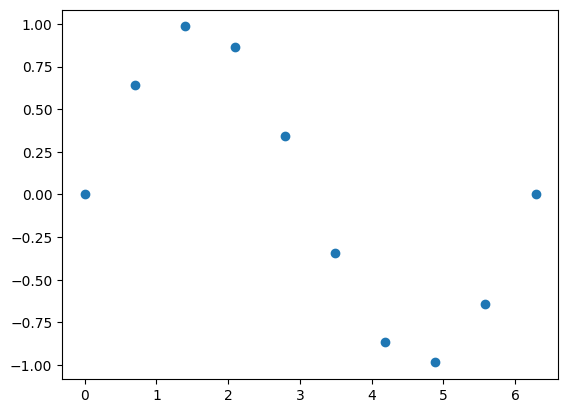

In [2]:
x = jnp.linspace(0, 2 * np.pi, 10)
y = jnp.sin(x)
plt.scatter(x, y);

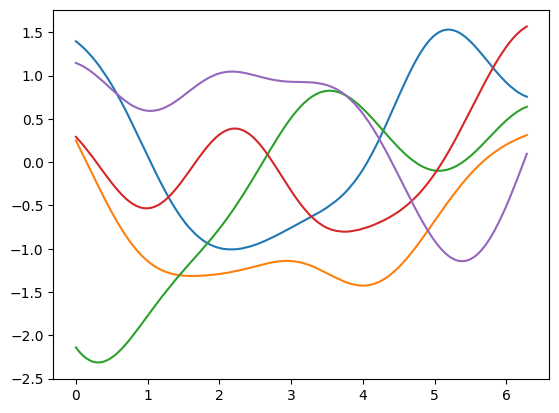

In [3]:
xx = jnp.linspace(0, 2 * np.pi, 1_000)
kernel = tinygp.kernels.ExpSquared(scale = 1)
gp = tinygp.GaussianProcess(kernel, xx)
yy = gp.sample(jax.random.PRNGKey(0), shape = (5,))
plt.plot(xx, yy.T);

In [4]:
def model():
    loc = numpyro.sample('loc', numpyro.distributions.Uniform(-1, 1))
    scale = numpyro.sample('scale', numpyro.distributions.Uniform(0, 2))
    length = numpyro.sample('length', numpyro.distributions.Uniform(0, 5))
    kernel = scale * tinygp.kernels.ExpSquared(scale = length)
    gp = tinygp.GaussianProcess(kernel, x)
    numpyro.sample('gp', gp.numpyro_dist(), obs = y)

In [5]:
nuts = numpyro.infer.NUTS(model)
mcmc = numpyro.infer.MCMC(nuts, num_warmup = 1_000, num_samples = 1_000)
mcmc.run(jax.random.PRNGKey(0))
mcmc.print_summary()

sample: 100%|████████| 2000/2000 [00:03<00:00, 525.35it/s, 7 steps of size 5.48e-01. acc. prob=0.90]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
    length      2.30      0.15      2.31      2.05      2.56    503.34      1.00
       loc     -0.01      0.59     -0.04     -0.80      0.98    561.90      1.00
     scale      1.46      0.37      1.51      0.93      1.99    527.59      1.00

Number of divergences: 0


In [6]:
posterior = mcmc.get_samples()

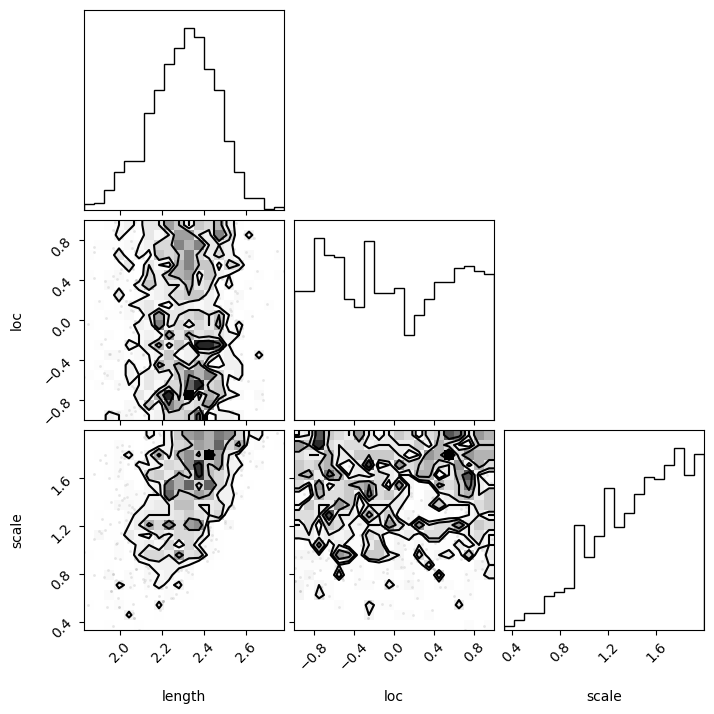

In [7]:
corner(
    np.transpose(list(posterior.values())),
    labels = list(posterior.keys()),
);

In [8]:
def predictive(key, loc, scale, length):
    kernel = scale * tinygp.kernels.ExpSquared(scale = length)
    gp = tinygp.GaussianProcess(kernel, xx)
    return gp.sample(key)

In [11]:
import tqdm

In [12]:
keys = jax.random.split(jax.random.PRNGKey(2), mcmc.num_samples)
ys = []
for key, loc, scale, length in tqdm.std.tqdm(
    zip(keys, posterior['loc'], posterior['scale'], posterior['length']),
    total = mcmc.num_samples,
):
    ys.append(predictive(key, loc, length, scale))

100%|███████████████████████████████████████████████████████████| 1000/1000 [02:13<00:00,  7.48it/s]


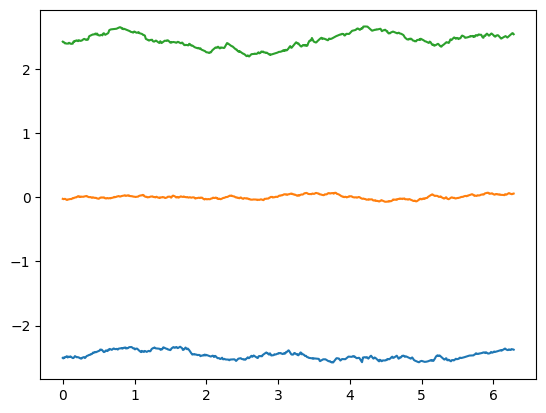

In [13]:
plt.plot(xx, np.quantile(ys, (0.05, 0.5, 0.95), axis = 0).T);